In [4]:
import time
from joblib import Parallel, delayed
import xarray as xr
import pandas as pd
import scipy as sp
import numpy as np
from pathlib import Path
from os import listdir, makedirs, remove
from os.path import isfile, join, exists
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
from cartopy import crs
from sklearn import metrics

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)
# show all rows
pd.set_option('display.max_rows', None)
# # hide warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Define functions

In [15]:
def filter_nan(s,o):
    """
    this functions removed the data  from simulated and observed data
    whereever the observed data contains nan
    s: simulated
    o: observed
    """
    if np.sum(~np.isnan(s*o))>=1:
#         data = np.array([s.flatten(),o.flatten()])
        data = np.array([s,o])
        data = np.transpose(data)
        data = data[~np.isnan(data).any(1)]
        s = data[:,0]
        o = data[:,1]
    return s, o

def correlation(s,o):
    """
    correlation coefficient
        s: simulated
        o: observed
        correlation: correlation coefficient
    """
    s,o = filter_nan(s,o)
    if s.size == 0:
        corr = np.NaN
    else:
        corr = np.corrcoef(o, s)[0,1]
        
    return corr

def rmse(s,o):
    """
    Root Mean Squared Error
    s: simulated
    o: observed
    rmses: root mean squared error
    """
    s,o = filter_nan(s,o)
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    s: simulated
    o: observed
    """
    s,o = filter_nan(s,o)
    return np.mean(abs(s-o))

def bias(s,o):
    """
    Bias
    s: simulated
    o: observed
    """
    s,o = filter_nan(s,o)
    return np.mean(s-o)

def index_agreement(s, o):
    """index of agreement Willmott (1981, 1982) 
        s: simulated
        o: observed
        ia: index of agreement
    """
    s,o = filter_nan(s,o)
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

def rdmf(a, b):
    """
    Calculate the relative difference (a-b) from b 
    then calculate the mean and its standard deviation.
    Returns (mean_relative_difference, std_relative_difference).
    Both a and b should be 1D arrays or lists of the same length.
    Ignores pairs where either value is NaN.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    a = a[mask]
    b = b[mask]
    # Avoid division by zero: set denominator to 1 where b==0 and a==0
    denom = b.copy()
    denom[denom == 0] = np.nan  # will result in nan for those pairs
    rel_diff = (a - b) / denom * 100
    mean_rel_diff = np.nanmean(rel_diff)
    std_rel_diff = np.nanstd(rel_diff)
    return mean_rel_diff, std_rel_diff

def rpd(a, b):
    """
    Calculate the Relative Percentage Difference (RPD) and its standard deviation between two arrays.
    RPD = 100 * |a - b| / ((a + b) / 2)
    Returns (mean_rpd, std_rpd), ignoring pairs where either value is NaN.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    mask = ~np.isnan(a) & ~np.isnan(b)
    a = a[mask]
    b = b[mask]
    denominator = (a + b) / 2
    denominator[denominator == 0] = np.nan  # Avoid division by zero
    rpd_values = 100 * np.abs(a - b) / denominator
    mean_rpd = np.nanmean(rpd_values)
    std_rpd = np.nanstd(rpd_values)
    return mean_rpd, std_rpd

def get_darray_r(array_r,darray_temp):
    """convert array r to xarray dataarray
        array_r: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_r = xr.DataArray(
        array_r,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Pearson correlation coefficient"
        )
    )
    darray_r.name = "r"
    darray_r.attrs["units"] = "1"
    darray_r.attrs["long_name"] = "Pearson correlation coefficient"

    darray_r.lon.attrs['units'] = "degrees_east"
    darray_r.lon.attrs['long_name'] = "longitude in degree east"
    darray_r.lon.attrs['description'] = "grid cell centers"
    darray_r.lon.attrs['axis'] = "X"

    darray_r.lat.attrs['units'] = "degrees_north"
    darray_r.lat.attrs['long_name'] = "longitude in degree north"
    darray_r.lat.attrs['description'] = "grid cell centers"
    darray_r.lat.attrs['axis'] = "Y"
    return darray_r

def get_darray_rmse(array_rmse,darray_temp):
    """convert array rmse to xarray dataarray
        darray_rmse: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_rmse = xr.DataArray(
        array_rmse,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Root Mean Squared Error"
        )
    )
    darray_rmse.name = "rmse"
    darray_rmse.attrs["units"] = "ppm per (micromol m-2 s-1)"
    darray_rmse.attrs["long_name"] = "Root Mean Squared Error"

    darray_rmse.lon.attrs['units'] = "degrees_east"
    darray_rmse.lon.attrs['long_name'] = "longitude in degree east"
    darray_rmse.lon.attrs['description'] = "grid cell centers"

    darray_rmse.lat.attrs['units'] = "degrees_north"
    darray_rmse.lat.attrs['long_name'] = "longitude in degree north"
    darray_rmse.lat.attrs['description'] = "grid cell centers"
    return darray_rmse

def get_darray_mae(array_mae,darray_temp):
    """convert array mae to xarray dataarray
        darray_mae: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_mae = xr.DataArray(
        array_mae,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Mean Absolute Error"
        )
    )
    darray_mae.name = "mae"
    darray_mae.attrs["units"] = "ppm per (micromol m-2 s-1)"
    darray_mae.attrs["long_name"] = "Mean Absolute Error"

    darray_mae.lon.attrs['units'] = "degrees_east"
    darray_mae.lon.attrs['long_name'] = "longitude in degree east"
    darray_mae.lon.attrs['description'] = "grid cell centers"

    darray_mae.lat.attrs['units'] = "degrees_north"
    darray_mae.lat.attrs['long_name'] = "longitude in degree north"
    darray_mae.lat.attrs['description'] = "grid cell centers"
    return darray_mae

def get_darray_bias(array_bias,darray_temp):
    """convert array bias to xarray dataarray
        darray_bias: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_bias = xr.DataArray(
        array_bias,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Mean Error"
        )
    )
    darray_bias.name = "bias"
    darray_bias.attrs["units"] = "ppm per (micromol m-2 s-1)"
    darray_bias.attrs["long_name"] = "Mean Error"

    darray_bias.lon.attrs['units'] = "degrees_east"
    darray_bias.lon.attrs['long_name'] = "longitude in degree east"
    darray_bias.lon.attrs['description'] = "grid cell centers"

    darray_bias.lat.attrs['units'] = "degrees_north"
    darray_bias.lat.attrs['long_name'] = "longitude in degree north"
    darray_bias.lat.attrs['description'] = "grid cell centers"
    return darray_bias

def get_darray_IoA(array_IoA,darray_temp):
    """convert array IoA to xarray dataarray
        darray_IoA: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_IoA = xr.DataArray(
        array_IoA,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Index of agreement"
        )
    )
    darray_IoA.name = "IoA"
    darray_IoA.attrs["units"] = "1"
    darray_IoA.attrs["long_name"] = "Index of agreement"

    darray_IoA.lon.attrs['units'] = "degrees_east"
    darray_IoA.lon.attrs['long_name'] = "longitude in degree east"
    darray_IoA.lon.attrs['description'] = "grid cell centers"

    darray_IoA.lat.attrs['units'] = "degrees_north"
    darray_IoA.lat.attrs['long_name'] = "longitude in degree north"
    darray_IoA.lat.attrs['description'] = "grid cell centers"
    return darray_IoA

def get_darray_rpd(array_rpd,darray_temp):
    """convert array rpd to xarray dataarray
        darray_rpd: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_rpd = xr.DataArray(
        array_rpd,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Relative percentage difference"
        )
    )
    darray_rpd.name = "rpd"
    darray_rpd.attrs["units"] = "%"
    darray_rpd.attrs["long_name"] = "Relative percentage difference"

    darray_rpd.lon.attrs['units'] = "degrees_east"
    darray_rpd.lon.attrs['long_name'] = "longitude in degree east"
    darray_rpd.lon.attrs['description'] = "grid cell centers"
    darray_rpd.lon.attrs['axis'] = "X"

    darray_rpd.lat.attrs['units'] = "degrees_north"
    darray_rpd.lat.attrs['long_name'] = "longitude in degree north"
    darray_rpd.lat.attrs['description'] = "grid cell centers"
    darray_rpd.lat.attrs['axis'] = "Y"
    return darray_rpd

def get_darray_rdmf(array_rdmf,darray_temp):
    """convert array rdmf to xarray dataarray
        darray_rdmf: target array
        darray_temp: provide darray shape, i.e. lon and lat for the array
    """
    darray_rdmf = xr.DataArray(
        array_rdmf,
        dims=["lat","lon"],
        coords=dict(
            lat = np.array(darray_temp['lat']),
            lon = np.array(darray_temp['lon'])
        ),
        attrs = dict(
            description = "Relative difference of the mean footprint"
        )
    )
    darray_rdmf.name = "rdmf"
    darray_rdmf.attrs["units"] = "%"
    darray_rdmf.attrs["long_name"] = "Relative difference of the mean footprint"

    darray_rdmf.lon.attrs['units'] = "degrees_east"
    darray_rdmf.lon.attrs['long_name'] = "longitude in degree east"
    darray_rdmf.lon.attrs['description'] = "grid cell centers"
    darray_rdmf.lon.attrs['axis'] = "X"

    darray_rdmf.lat.attrs['units'] = "degrees_north"
    darray_rdmf.lat.attrs['long_name'] = "longitude in degree north"
    darray_rdmf.lat.attrs['description'] = "grid cell centers"
    darray_rdmf.lat.attrs['axis'] = "Y"
    return darray_rdmf

def get_6stat(DataArray1, DataArray2):
    """
    Compute 6 statistics (correlation, rmse, mae, bias, index_agreement, rdmf) grid-wise
    between two xarray DataArrays with shape (time, lat, lon).
    Returns: tuple of 2D numpy arrays (r, rmse, mae, bias, IoA, rdmf)
    """
    nlat = len(DataArray1['lat'])
    nlon = len(DataArray1['lon'])
    arr_corr = np.full((nlat, nlon), np.nan)
    arr_rmse = np.full((nlat, nlon), np.nan)
    arr_mae = np.full((nlat, nlon), np.nan)
    arr_bias = np.full((nlat, nlon), np.nan)
    arr_IoA = np.full((nlat, nlon), np.nan)
    arr_rpd = np.full((nlat, nlon), np.nan)

    for ilat in range(nlat):
        for ilon in range(nlon):
            ts1 = DataArray1[:, ilat, ilon].values
            ts2 = DataArray2[:, ilat, ilon].values
            arr_corr[ilat, ilon] = correlation(ts1, ts2)
            arr_rmse[ilat, ilon] = rmse(ts1, ts2)
            arr_mae[ilat, ilon] = mae(ts1, ts2)
            arr_bias[ilat, ilon] = bias(ts1, ts2)
            arr_IoA[ilat, ilon] = index_agreement(ts1, ts2)
            arr_rpd[ilat, ilon], _ = rpd(ts1, ts2)
        if ilat % 20 == 0:
            print(ilat, end="..")
    print("done")
    return arr_corr, arr_rmse, arr_mae, arr_bias, arr_IoA, arr_rpd

def plot_conf_matrix(df_flexpart, df_stilt, yearmon, lt, threshold, ax):
    y_flexpart = df_flexpart>threshold
    y_stilt = df_stilt>threshold
    conf_matrix = metrics.confusion_matrix(y_stilt, y_flexpart)
    accuracy = round(np.sum(conf_matrix.diagonal())/np.sum(conf_matrix)*100,1)

    alpha = [f'<={threshold}',f'>{threshold}']
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.6)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    xaxis = np.arange(len(alpha))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(alpha)
    ax.set_yticklabels(alpha);
    ax.set_xlabel('Flexpart ∆14C', fontsize=12)
    ax.set_ylabel('Stilt ∆14C', fontsize=12)
    ax.set_title(f'{yearmon} {lt}LT, agreement={accuracy}%', fontsize=12, loc = "left")

def plot_hist(df_flexpart, df_stilt, yearmon,  ax):
    data1 = df_flexpart['mean']
    data2 = df_stilt['mean']

    nbin = [i*0.2 for i in range(50)]
    ax.hist(data1, bins=nbin, alpha=0.7, label='Flexpart afternoon ∆14C')
    ax.hist(data2, bins=nbin, alpha=0.7, label='Stilt afternoon ∆14C')

    ax.grid()
    ax.set_xlim(0,10)
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(11))
    ax.set_xlabel('∆14C, [‰]')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram Comparison, {yearmon}',loc = "left")
    ax.tick_params(axis='x', labelrotation = 0)
    ax.legend()

In [6]:
def merge_footprint(path, StationID, sdate, edate, fname="foot_nest", domain="eu"):
    """
    Merge hourly footprint files for a station over a period and save as NetCDF.

    Parameters:
        path (str): Base directory for FLEXPART output.
        StationID (str): Station identifier.
        sdate (str): Start date, format 'YYYY-MM-DD'.
        edate (str): End date, format 'YYYY-MM-DD'.
        fname (str): File name to read ('foot' or 'foot_nest').
        domain (str): Domain identifier for output file naming.
    """
    start_time = time.time()
    StationID = StationID.upper()
    period = pd.date_range(start=sdate, end=edate)
    darray_flexpart = None
    i = 0
    print(f"{StationID}: ", flush=True)
    for date in period:
        Year = str(date.year)
        Month = str(date.month).zfill(2)
        Day = str(date.day).zfill(2)
        for Hour in range(24):
            folder = f"{Year}x{Month}x{Day}x{str(Hour).zfill(2)}"
            file_path = f"{path}{StationID}/{Year}/{Month}/{folder}/{fname}"
            try:
                darray_temp = xr.open_dataarray(file_path)
                darray_temp = darray_temp.where(darray_temp != 0)
                if darray_flexpart is None:
                    darray_flexpart = darray_temp
                else:
                    darray_flexpart = xr.concat([darray_flexpart, darray_temp], dim="time")
            except Exception as e:
                print(f"Missing or error in file: {file_path} -- {e}")
        i += 1
        if i % 10 == 0:
            print(f"{date}...", end="", flush=True)
    if darray_flexpart is not None:
        file_path_name = f"{path}{StationID}/foot_{domain}_{sdate}_{edate}_flexpart.nc"
        if exists(file_path_name):
            remove(file_path_name)
        darray_flexpart.to_netcdf(file_path_name)
        print(f"\nSaved {file_path_name}")
    else:
        print(f"\nNo data found for {StationID} in period {sdate} to {edate}")
    elapsed_time = time.time() - start_time
    print(f"{StationID} took {elapsed_time:.2f} seconds")

In [7]:
def merge_delta14C(IN_PATH, OUT_PATH, StationID, sdate, edate, domain="eu"):
    """
    Merge hourly delta14C CSV files for a station over a period and save as NetCDF.

    Parameters:
        IN_PATH (str): Base directory for input CSV files.
        OUT_PATH (str): Output directory for merged NetCDF.
        StationID (str): Station identifier.
        sdate (str): Start date, format 'YYYY-MM-DD'.
        edate (str): End date, format 'YYYY-MM-DD'.
        domain (str): Domain identifier for output file naming.
    """
    StationID_upper = StationID.upper()
    period = pd.date_range(start=sdate, end=edate)
    dfs = []

    if domain == 'eu':
        suffix = 'eu'
    else:
        suffix = ''

    for date in period:
        Year = str(date.year)
        Month = str(date.month).zfill(2)
        Day = str(date.day).zfill(2)
        fname = f"delta_14C_{StationID.lower()}_{Year}{Month}{Day}{suffix}.csv"
        file_path = f"{IN_PATH}{StationID_upper}/{Year}/{Month}/{fname}"
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"Missing or error in file: {file_path} -- {e}")

    if not dfs:
        print(f"No data found for {StationID} in period {sdate} to {edate}")
        return

    df_all = pd.concat(dfs, ignore_index=True)
    # Try to sort by datetime if available
    if "datetime" in df_all.columns:
        df_all = df_all.sort_values("datetime")

    out_dir = f"{OUT_PATH}{StationID_upper}"
    if not exists(out_dir):
        makedirs(out_dir)

    out_file = join(out_dir, f"delta14C_{domain}_{sdate}_{edate}_flexpart.csv")
    df_all.to_csv(out_file, index=False)
    print(f"Saved {out_file}")


In [8]:
def merge_footprint_out(IN_PATH, OUT_PATH, StationID, sdate, edate, fname="foot_nest", domain="eu"):
    """
    Merge hourly footprint files for a station over a period and save as NetCDF to OUT_PATH.

    Parameters:
        IN_PATH (str): Base directory for FLEXPART input files.
        OUT_PATH (str): Output directory for merged NetCDF.
        StationID (str): Station identifier.
        sdate (str): Start date, format 'YYYY-MM-DD'.
        edate (str): End date, format 'YYYY-MM-DD'.
        fname (str): File name to read ('foot' or 'foot_nest').
        domain (str): Domain identifier for output file naming.
    """
    start_time = time.time()
    StationID = StationID.upper()
    period = pd.date_range(start=sdate, end=edate)
    darray_flexpart = None
    i = 0
    print(f"{StationID}: ", flush=True)
    for date in period:
        Year = str(date.year)
        Month = str(date.month).zfill(2)
        Day = str(date.day).zfill(2)
        for Hour in range(24):
            folder = f"{Year}x{Month}x{Day}x{str(Hour).zfill(2)}"
            file_path = f"{IN_PATH}{StationID}/{Year}/{Month}/{folder}/{fname}"
            try:
                darray_temp = xr.open_dataarray(file_path)
                darray_temp = darray_temp.where(darray_temp != 0)
                if darray_flexpart is None:
                    darray_flexpart = darray_temp
                else:
                    darray_flexpart = xr.concat([darray_flexpart, darray_temp], dim="time")
            except Exception as e:
                print(f"Missing or error in file: {file_path} -- {e}")
        i += 1
        if i % 5 == 0:
            print(f"{date}...", end="", flush=True)
    if darray_flexpart is not None:
        out_dir = join(OUT_PATH, StationID)
        if not exists(out_dir):
            makedirs(out_dir)
        file_path_name = join(out_dir, f"foot_{domain}_{sdate}_{edate}_flexpart.nc")
        if exists(file_path_name):
            remove(file_path_name)
        darray_flexpart.to_netcdf(file_path_name)
        print(f"\nSaved {file_path_name}")
    else:
        print(f"\nNo data found for {StationID} in period {sdate} to {edate}")
    elapsed_time = time.time() - start_time
    print(f"{StationID} took {elapsed_time:.2f} seconds")

In [9]:
def read_hour_file(file_path):
    try:
        darray_temp = xr.open_dataarray(file_path)
        return darray_temp.where(darray_temp != 0)
    except Exception as e:
        print(f"Missing or error in file: {file_path} -- {e}")
        return None

def merge_footprint_parallel(IN_PATH, OUT_PATH, StationID, sdate, edate, fname="foot_nest", domain="eu", ncpu=5):
    start_time = time.time()
    StationID = StationID.upper()
    period = pd.date_range(start=sdate, end=edate)
    file_paths = []
    print(f"{StationID}: {fname} for {domain} domain", flush=True)
    for date in period:
        Year = str(date.year)
        Month = str(date.month).zfill(2)
        Day = str(date.day).zfill(2)
        for Hour in range(24):
            folder = f"{Year}x{Month}x{Day}x{str(Hour).zfill(2)}"
            file_path = f"{IN_PATH}{StationID}/{Year}/{Month}/{folder}/{fname}"
            file_paths.append(file_path)
    # Parallel read
    results = Parallel(n_jobs=ncpu, verbose=5)(delayed(read_hour_file)(fp) for fp in file_paths)
    # Filter out None
    darrays = [r for r in results if r is not None]
    if darrays:
        darray_flexpart = xr.concat(darrays, dim="time")
        out_dir = join(OUT_PATH, StationID)
        if not exists(out_dir):
            makedirs(out_dir)
        file_path_name = join(out_dir, f"foot_{domain}_{sdate}_{edate}_flexpart.nc")
        if exists(file_path_name):
            remove(file_path_name)
        darray_flexpart.to_netcdf(file_path_name)
        print(f"\nSaved {file_path_name}")
    else:
        print(f"\nNo data found for {StationID} in period {sdate} to {edate}")
    elapsed_time = time.time() - start_time
    print(f"{StationID} took {elapsed_time:.2f} seconds")

In [ ]:
# # List all currently imported modules/packages in the notebook session
# import sys
# list(sys.modules.keys())
# # List all variables currently defined in the Jupyter notebook session
# %whos
# # Remove all variables starting with 'da_' from the current Jupyter notebook session
# for var in list(globals()):
#     if var.startswith('da_'):
#         del globals()[var]
# # Clear all variables in the current Jupyter notebook session
# %reset -f

# 2. Merge data

In [ ]:
# Define paths and parameters
lst_Station = ["htm150", "ope120", "gat341", "lin098", "cbw200"]
FLEXPARTv10_PATH = "/data/cupcake/flexpartweb/stations/"
FLEXPARTv11_PATH = "/data/cupcake/v11/flexpartweb/stations/"
FLEXPARTv10_EU_PATH = "/data/cupcake/flexpartweb/stations_eu/"
FLEXPARTv11_EU_PATH = "/data/cupcake/v11/flexpartweb/stations_eu/"
# OUTv10_PATH = "/data/flexpart/output/v10/flexpartweb/stations/"
# OUTv11_PATH = "/data/flexpart/output/v11/flexpartweb/stations/"
# OUTv10_EU_PATH = "/data/flexpart/output/v10/flexpartweb/stations_eu/"
# OUTv11_EU_PATH = "/data/flexpart/output/v11/flexpartweb/stations_eu/"
OUTv10_PATH = "./v10/flexpartweb/stations/"
OUTv11_PATH = "./v11/flexpartweb/stations/"
OUTv10_EU_PATH = "./v10/flexpartweb/stations_eu/"
OUTv11_EU_PATH = "./v11/flexpartweb/stations_eu/"
sdate = '2025-08-01'
edate = '2025-08-20'

## 2.1. Merge hourly footprint

In [ ]:
# Merge footprint files for each station and domain
for StationID in lst_Station:
    # merge_footprint(FLEXPARTv10_PATH, StationID, sdate, edate, fname="foot", domain="global")
    # merge_footprint(FLEXPARTv11_PATH, StationID, sdate, edate, fname="foot", domain="global")
    # merge_footprint(FLEXPARTv10_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    # merge_footprint(FLEXPARTv11_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    # merge_footprint(FLEXPARTv10_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")
    # merge_footprint(FLEXPARTv11_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")
    # merge_footprint_out(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, fname="foot", domain="global")
    # merge_footprint_out(FLEXPARTv11_PATH, OUTv11_PATH, StationID, sdate, edate, fname="foot", domain="global")
    # merge_footprint_out(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    # merge_footprint_out(FLEXPARTv11_PATH, OUTv11_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    # merge_footprint_out(FLEXPARTv10_EU_PATH, OUTv10_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")
    # merge_footprint_out(FLEXPARTv11_EU_PATH, OUTv11_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")
    merge_footprint_parallel(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, fname="foot", domain="global")
    merge_footprint_parallel(FLEXPARTv11_PATH, OUTv11_PATH, StationID, sdate, edate, fname="foot", domain="global")
    merge_footprint_parallel(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    merge_footprint_parallel(FLEXPARTv11_PATH, OUTv11_PATH, StationID, sdate, edate, fname="foot_nest", domain="global_nest")
    merge_footprint_parallel(FLEXPARTv10_EU_PATH, OUTv10_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")
    merge_footprint_parallel(FLEXPARTv11_EU_PATH, OUTv11_EU_PATH, StationID, sdate, edate, fname="foot", domain="eu")


In [1]:
# sdate = '2025-08-01'
# edate = '2025-08-10'
# StationID = "htm150"
# merge_footprint_out(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, fname="foot", domain="global")


## 2.2. Merge hourly delta radiocarbon contribution (permil) 

In [ ]:
# Merge delta 14C files for each station and domain
for StationID in lst_Station:
    merge_delta14C(FLEXPARTv10_PATH, OUTv10_PATH, StationID, sdate, edate, domain="global_nest")
    merge_delta14C(FLEXPARTv11_PATH, OUTv11_PATH, StationID, sdate, edate, domain="global_nest")
    merge_delta14C(FLEXPARTv10_EU_PATH, OUTv10_EU_PATH, StationID, sdate, edate, domain="eu")
    merge_delta14C(FLEXPARTv11_EU_PATH, OUTv11_EU_PATH, StationID, sdate, edate, domain="eu")

# 3. Compare footprint

In [21]:
OUTv10_PATH = "D:/data/flexpart/v10/flexpartweb/stations/"
OUTv11_PATH = "D:/data/flexpart/v11/flexpartweb/stations/"
OUTv10_EU_PATH = "D:/data/flexpart/v10/flexpartweb/stations_eu/"
OUTv11_EU_PATH = "D:/data/flexpart/v11/flexpartweb/stations_eu/"
sdate = '2025-08-01'
edate = '2025-08-20'
domain="global"
StationID = "OPE120"

## 3.1. Calculate statistics

In [22]:
file_path_name = join(OUTv10_PATH+StationID+"/", f"foot_{domain}_{sdate}_{edate}_flexpart.nc")
da_flexpartv10_global = xr.open_dataarray(file_path_name)
file_path_name = join(OUTv11_PATH+StationID+"/", f"foot_{domain}_{sdate}_{edate}_flexpart.nc")
da_flexpartv11_global = xr.open_dataarray(file_path_name)
# Create a mask where all values in the time dimension for each grid cell are NaN (over the whole period)
allnanv10_mask = np.all(np.isnan(da_flexpartv10_global.values), axis=0)  # shape: (lat, lon)
allnanv11_mask = np.all(np.isnan(da_flexpartv11_global.values), axis=0)  # shape: (lat, lon)


In [23]:
# Calculate grid-wise statistics between da_flexpartv10_global and da_flexpartv11_global

# nlat = len(da_flexpartv10_global['lat'])
# nlon = len(da_flexpartv10_global['lon'])

# arr_corr = np.full((nlat, nlon), np.nan)
# arr_rmse = np.full((nlat, nlon), np.nan)
# arr_mae = np.full((nlat, nlon), np.nan)
# arr_bias = np.full((nlat, nlon), np.nan)
# arr_IoA = np.full((nlat, nlon), np.nan)
# arr_rpd = np.full((nlat, nlon), np.nan)

# for ilat in range(nlat):
#     for ilon in range(nlon):
#         v10 = da_flexpartv10_global[:, ilat, ilon].values
#         v11 = da_flexpartv11_global[:, ilat, ilon].values
#         arr_corr[ilat, ilon] = correlation(v10, v11)
#         arr_rmse[ilat, ilon] = rmse(v10, v11)
#         arr_mae[ilat, ilon] = mae(v10, v11)
#         arr_bias[ilat, ilon] = bias(v10, v11)
#         arr_IoA[ilat, ilon] = index_agreement(v10, v11)
#         arr_rpd[ilat, ilon], _ = rpd(v10, v11)
#     if ilat % 20 == 0:
#         print(ilat, end="..")
# print("done")

arr_corr, arr_rmse, arr_mae, arr_bias, arr_IoA, arr_rpd = get_6stat(da_flexpartv10_global, da_flexpartv11_global)

# Example: wrap as xarray DataArray for further analysis or plotting
da_corr = get_darray_r(arr_corr, da_flexpartv10_global)
da_rmse = get_darray_rmse(arr_rmse, da_flexpartv10_global)
da_mae = get_darray_mae(arr_mae, da_flexpartv10_global)
da_bias = get_darray_bias(arr_bias, da_flexpartv10_global)
da_IoA = get_darray_IoA(arr_IoA, da_flexpartv10_global)
da_rpd = get_darray_rpd(arr_rpd, da_flexpartv10_global)


0..20..40..60..80..100..120..140..160..done


In [24]:
# Daily sum for each grid cell (sum over each day), skip NaN, set all-NaN to NaN
# Create a mask where all values in the time dimension for each grid cell are NaN (over the whole period)
allnanv10_mask = np.all(np.isnan(da_flexpartv10_global.values), axis=0)  # shape: (lat, lon)
da_v10_daily = da_flexpartv10_global.resample(time="1D").sum(dim="time")
# Set result to NaN where all values were NaN
da_v10_daily = da_v10_daily.where(~allnanv10_mask, np.nan)

allnanv11_mask = np.all(np.isnan(da_flexpartv11_global.values), axis=0)  # shape: (lat, lon)
da_v11_daily = da_flexpartv11_global.resample(time="1D").sum(dim="time")
# Set result to NaN where all values were NaN
da_v11_daily = da_v11_daily.where(~allnanv11_mask, np.nan)

# Run get_6stat on daily summed data
arr_corr, arr_rmse, arr_mae, arr_bias, arr_IoA, arr_rpd = get_6stat(da_v10_daily, da_v11_daily)
# Optionally wrap as DataArrays for further analysis/plotting
da_corr_daily = get_darray_r(arr_corr, da_v10_daily)
da_rmse_daily = get_darray_rmse(arr_rmse, da_v10_daily)
da_mae_daily = get_darray_mae(arr_mae, da_v10_daily)
da_bias_daily = get_darray_bias(arr_bias, da_v10_daily)
da_IoA_daily = get_darray_IoA(arr_IoA, da_v10_daily)
da_rpd_daily = get_darray_rpd(arr_rpd, da_v10_daily)

0..20..40..60..80..100..120..140..160..done


In [25]:
# Save all statistics as NetCDF files with StationID, domain, sdate, edate in the filename
outdir = "./stats"
if not exists(outdir):
    makedirs(outdir)

for da, name in zip(
    [da_corr, da_rmse, da_mae, da_bias, da_IoA, da_rpd],
    ["corr", "rmse", "mae", "bias", "IoA", "rpd"]
):
    fname = f"{StationID}_{domain}_{sdate}_{edate}_{name}.nc"
    fpath = join(outdir, fname)
    if exists(fpath):
        remove(fpath)
    da.to_netcdf(fpath)
    print(f"Saved {fpath}")

for da, name in zip(
    [da_corr_daily, da_rmse_daily, da_mae_daily, da_bias_daily, da_IoA_daily, da_rpd_daily],
    ["corr", "rmse", "mae", "bias", "IoA", "rpd"]
):
    fname = f"{StationID}_{domain}_{sdate}_{edate}_{name}_daily.nc"
    fpath = join(outdir, fname)
    if exists(fpath):
        remove(fpath)
    da.to_netcdf(fpath)
    print(f"Saved {fpath}")

Saved ./stats\OPE120_global_2025-08-01_2025-08-20_corr.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_rmse.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_mae.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_bias.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_IoA.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_rpd.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_corr_daily.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_rmse_daily.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_mae_daily.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_bias_daily.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_IoA_daily.nc
Saved ./stats\OPE120_global_2025-08-01_2025-08-20_rpd_daily.nc


## 3.2. Plot

In [53]:
plot_dir = "./plot"
if not exists(plot_dir):
    makedirs(plot_dir)

In [26]:
stats_dir = "./stats"
da_corr  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_corr.nc"))
da_rmse  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_rmse.nc"))
da_mae   = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_mae.nc"))
da_bias  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_bias.nc"))
da_IoA   = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_IoA.nc"))
da_rpd  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_rpd.nc"))
da_corr_daily  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_corr_daily.nc"))
da_rmse_daily  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_rmse_daily.nc"))
da_mae_daily   = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_mae_daily.nc"))
da_bias_daily  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_bias_daily.nc"))
da_IoA_daily   = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_IoA_daily.nc"))
da_rpd_daily  = xr.open_dataarray(join(stats_dir, f"{StationID}_{domain}_{sdate}_{edate}_rpd_daily.nc"))

da_corr.close()  # This releases the file handle
da_rmse.close()
da_mae.close()
da_bias.close()
da_IoA.close()
da_rpd.close()
da_corr_daily.close()
da_rmse_daily.close()
da_mae_daily.close()
da_bias_daily.close()
da_IoA_daily.close()
da_rpd_daily.close()

In [27]:
# Set da_IoA to NaN where all values were NaN in either v10 or v11
nan_mask = allnanv10_mask | allnanv11_mask
da_IoA = da_IoA.where(~nan_mask, np.nan)
da_rpd = da_rpd.where(~nan_mask, np.nan)
# Negative IoA means the model is performing worse than simply using
# the mean of the observations as a predictor. It is a sign of very
# poor agreement between model and observations for those grid cells.
negative_mask = da_IoA < 0
num_negative = np.sum(negative_mask.values)
print(f"Number of grid cells with negative IoA: {num_negative}")
# Set negative IoA values to NaN
da_IoA = da_IoA.where(da_IoA >= 0, np.nan)


Number of grid cells with negative IoA: 11


In [37]:
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), subplot_kw={'projection': crs.PlateCarree()})
# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs
# fig.suptitle('Grid-wise Comparison: v10 vs v11', fontsize=18, fontweight='bold')

# # Plot settings for each statistic
# # plots = [
# #     (da_corr, ax1, "a. Correlation Coefficient", "RdBu", np.linspace(-1, 1, 11), {'label': '1', 'ticks': np.linspace(-1, 1, 11)}, -1, 1),
# #     (da_rmse, ax2, "b. Root Mean Squared Error", "viridis", np.linspace(0, np.nanmax(da_rmse), 11), {'label': 'RMSE', 'ticks': np.linspace(0, np.nanmax(da_rmse), 11)}, 0, np.nanmax(da_rmse)),
# #     (da_mae, ax3, "c. Mean Absolute Error", "viridis", np.linspace(0, np.nanmax(da_mae), 11), {'label': 'MAE', 'ticks': np.linspace(0, np.nanmax(da_mae), 11)}, 0, np.nanmax(da_mae)),
# #     (da_bias, ax4, "d. Mean Error (Bias)", "RdBu", np.linspace(np.nanmin(da_bias), np.nanmax(da_bias), 11), {'label': 'Bias', 'ticks': np.linspace(np.nanmin(da_bias), np.nanmax(da_bias), 11)}, np.nanmin(da_bias), np.nanmax(da_bias)),
# #     (da_IoA, ax5, "e. Index of Agreement", "YlGn", np.linspace(0, 1, 11), {'label': 'IoA', 'ticks': np.linspace(0, 1, 11)}, 0, 1),
# #     (da_rdmf, ax6, "f. RDMF (%)", "coolwarm", np.linspace(np.nanmin(da_rdmf), np.nanmax(da_rdmf), 11), {'label': '%', 'ticks': np.linspace(np.nanmin(da_rdmf), np.nanmax(da_rdmf), 11)}, np.nanmin(da_rdmf), np.nanmax(da_rdmf)),
# # ]

# plots = [
#     (da_corr, ax1, "a. Correlation Coefficient", plt.get_cmap("RdBu_r",10), {'label': '1', 'ticks': np.linspace(-1, 1, 11)}, -1, 1),
#     (da_rmse, ax2, "b. Root Mean Squared Error", plt.get_cmap("terrain_r",10), {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.01, 11)}, 0, 0.01),
#     (da_mae, ax3, "c. Mean Absolute Error", plt.get_cmap("terrain_r",10), {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.01, 11)}, 0, 0.01),
#     (da_bias, ax4, "d. Mean Error (Bias)", plt.get_cmap("RdBu_r",10), {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(-0.01, 0.01, 11)}, -0.01, 0.01),
#     (da_IoA, ax5, "e. Index of Agreement", "YlGn", {'label': 'IoA', 'ticks': np.linspace(0, 1, 11)}, 0, 1),
#     (da_rdmf, ax6, "f. RDMF (%)", "coolwarm", {'label': '%', 'ticks': np.linspace(np.nanmin(da_rdmf), np.nanmax(da_rdmf), 11)}, np.nanmin(da_rdmf), np.nanmax(da_rdmf)),
# ]

# for da, ax, title, cmap, cbar_kwargs, vmin, vmax in plots:
#     da.plot(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)
#     ax.set_title(title)
#     ax.set_xlabel("Longitude")
#     ax.set_ylabel("Latitude")
#     ax.coastlines()

# plt.tight_layout()
# plt.show()

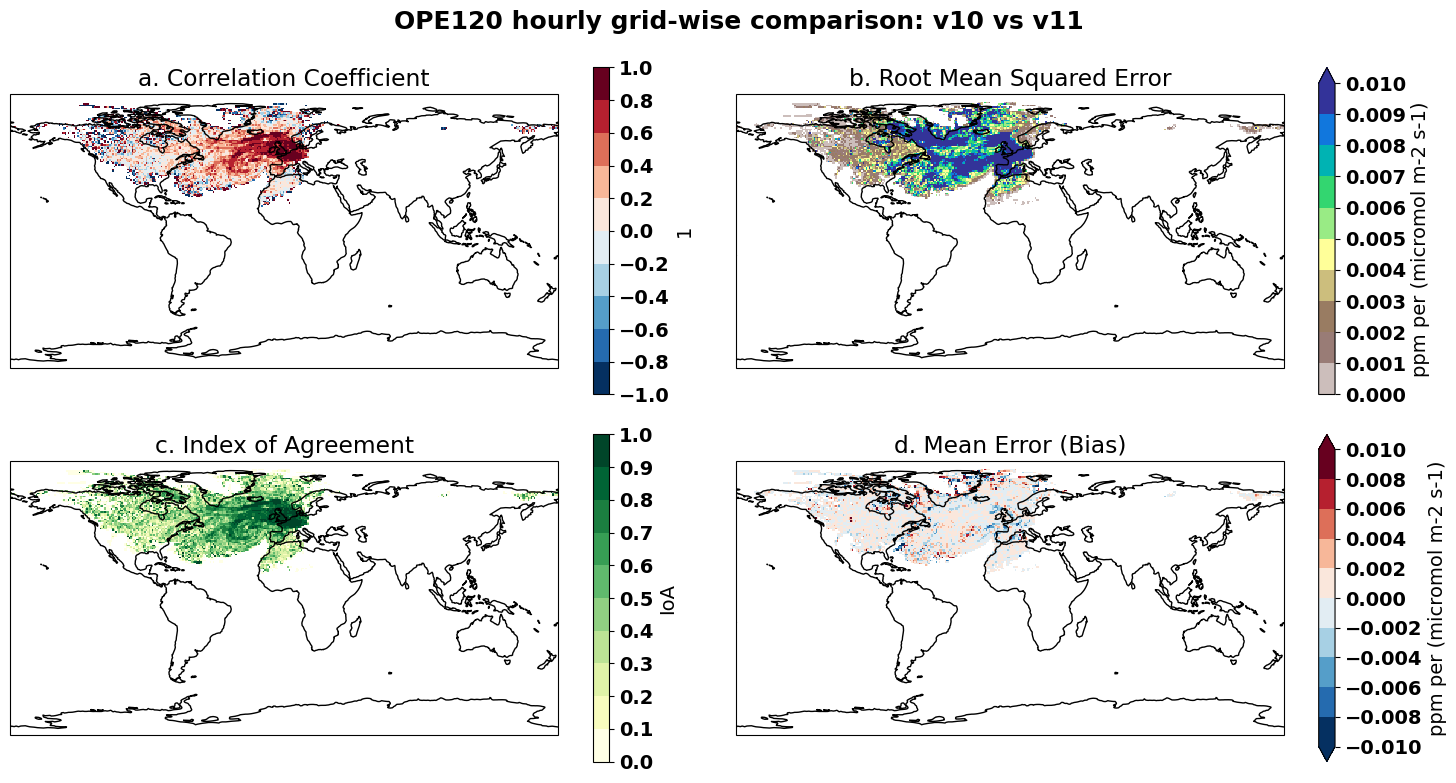

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), subplot_kw={'projection': crs.PlateCarree()})
(ax1, ax2), (ax3, ax4) = axs
fig.suptitle(f'{StationID} hourly grid-wise comparison: v10 vs v11', fontsize=18, fontweight='bold')

terrain_r = plt.get_cmap("terrain_r", 11)
terrain_r_skipwhite = colors.ListedColormap(terrain_r(np.arange(1, 11)))

plots = [
    (da_corr, ax1, "a. Correlation Coefficient", plt.get_cmap("RdBu_r",10), {'label': '1', 'ticks': np.linspace(-1, 1, 11)}, -1, 1),
    (da_rmse, ax2, "b. Root Mean Squared Error", terrain_r_skipwhite, {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.01, 11)}, 0, 0.01),
    # (da_mae, ax3, "c. Mean Absolute Error", terrain_r_skipwhite, {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.01, 11)}, 0, 0.01),
    (da_IoA, ax3, "c. Index of Agreement", plt.get_cmap("YlGn",10), {'label': 'IoA', 'ticks': np.linspace(0, 1, 11)}, 0, 1),
    (da_bias, ax4, "d. Mean Error (Bias)", plt.get_cmap("RdBu_r",10), {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(-0.01, 0.01, 11)}, -0.01, 0.01),
    # (da_rpd, ax4, "d. RPD (%)", plt.get_cmap("seismic",10), {'label': '%', 'ticks': np.linspace(-100, 100, 11)}, -100, 100),
]

for da, ax, title, cmap, cbar_kwargs, vmin, vmax in plots:
    da.plot(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.coastlines()

plt.tight_layout()
fig.savefig(f"./plot/{StationID}_hourly_footprint.png", dpi=300)
plt.show()

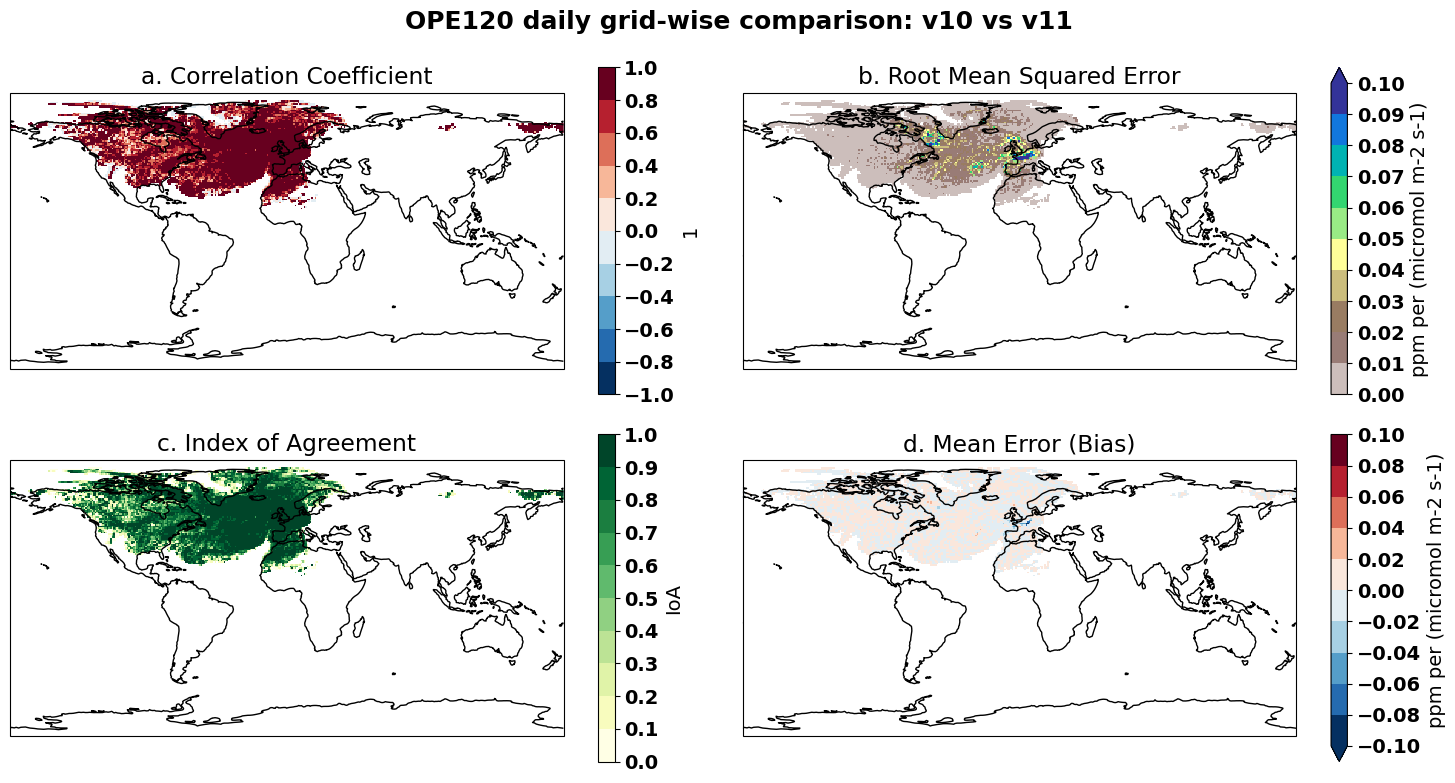

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), subplot_kw={'projection': crs.PlateCarree()})
(ax1, ax2), (ax3, ax4) = axs
fig.suptitle(f'{StationID} daily grid-wise comparison: v10 vs v11', fontsize=18, fontweight='bold')

terrain_r = plt.get_cmap("terrain_r", 11)
terrain_r_skipwhite = colors.ListedColormap(terrain_r(np.arange(1, 11)))

plots = [
    (da_corr_daily, ax1, "a. Correlation Coefficient", plt.get_cmap("RdBu_r",10), {'label': '1', 'ticks': np.linspace(-1, 1, 11)}, -1, 1),
    (da_rmse_daily, ax2, "b. Root Mean Squared Error", terrain_r_skipwhite, {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.1, 11)}, 0, 0.1),
    # (da_mae_daily, ax3, "c. Mean Absolute Error", terrain_r_skipwhite, {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(0, 0.1, 11)}, 0, 0.1),
    (da_IoA_daily, ax3, "c. Index of Agreement", plt.get_cmap("YlGn",10), {'label': 'IoA', 'ticks': np.linspace(0, 1, 11)}, 0, 1),
    (da_bias_daily, ax4, "d. Mean Error (Bias)", plt.get_cmap("RdBu_r",10), {'label': 'ppm per (micromol m-2 s-1)', 'ticks': np.linspace(-0.1, 0.1, 11)}, -0.1, 0.1),
    # (da_rpd_daily, ax4, "d. RPD (%)", plt.get_cmap("seismic",10), {'label': '%', 'ticks': np.linspace(-100, 100, 11)}, -100, 100),
]

for da, ax, title, cmap, cbar_kwargs, vmin, vmax in plots:
    da.plot(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.coastlines()

plt.tight_layout()
fig.savefig(f"./plot/{StationID}_daily_footprint.png", dpi=300)
plt.show()


# 4. Compare delta radiocarbon contributions between FLEXPART v10 and v11

In [32]:
OUTv10_PATH = "D:/data/flexpart/v10/flexpartweb/stations/"
OUTv11_PATH = "D:/data/flexpart/v11/flexpartweb/stations/"
OUTv10_EU_PATH = "D:/data/flexpart/v10/flexpartweb/stations_eu/"
OUTv11_EU_PATH = "D:/data/flexpart/v11/flexpartweb/stations_eu/"
sdate = '2025-08-01'
edate = '2025-08-20'
domain="global_nest"
StationID = "OPE120"

In [40]:
file_path_name = join(OUTv10_PATH, StationID, f"delta14C_{domain}_{sdate}_{edate}_flexpart.csv")
df_delta14C_v10 = pd.read_csv(file_path_name)
file_path_name = join(OUTv11_PATH, StationID, f"delta14C_{domain}_{sdate}_{edate}_flexpart.csv")
df_delta14C_v11 = pd.read_csv(file_path_name)

# delta_14C_flexpart = df_delta14C_v10.set_index("datetime")
# delta_14C_stilt = df_delta14C_v11.set_index("datetime")
df_delta14C_v10["datetime"] = pd.to_datetime(df_delta14C_v10["datetime"])
df_delta14C_v11["datetime"] = pd.to_datetime(df_delta14C_v11["datetime"])


In [37]:
r_plot = correlation(df_delta14C_v10["14C"],df_delta14C_v11["14C"])
rmse_plot = rmse(df_delta14C_v10["14C"],df_delta14C_v11["14C"])
mae_plot = mae(df_delta14C_v10["14C"],df_delta14C_v11["14C"])
bias_plot = bias(df_delta14C_v10["14C"],df_delta14C_v11["14C"])
IoA_plot = index_agreement(df_delta14C_v10["14C"],df_delta14C_v11["14C"])
rpd_plot,_ = rpd(df_delta14C_v10["14C"],df_delta14C_v11["14C"])

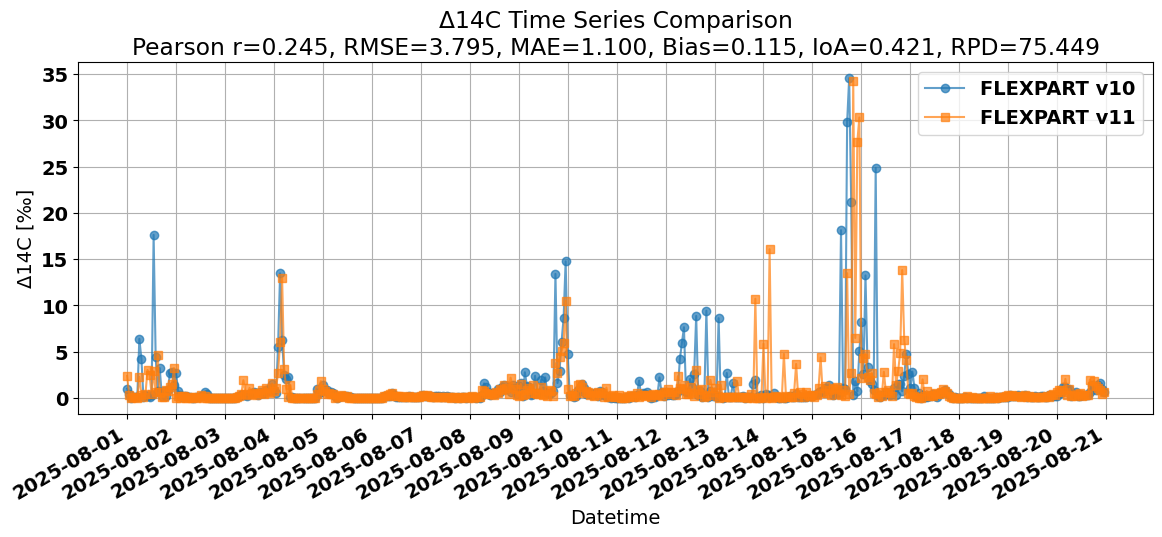

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_delta14C_v10['datetime'], df_delta14C_v10['14C'], label='FLEXPART v10', marker='o', linestyle='-', alpha=0.7)
plt.plot(df_delta14C_v11['datetime'], df_delta14C_v11['14C'], label='FLEXPART v11', marker='s', linestyle='-', alpha=0.7)
plt.xlabel('Datetime')
plt.ylabel('Δ14C [‰]')
plt.title(
    f'Δ14C Time Series Comparison\n'
    f'Pearson r={r_plot:.3f}, RMSE={rmse_plot:.3f}, MAE={mae_plot:.3f}, '
    f'Bias={bias_plot:.3f}, IoA={IoA_plot:.3f}, RPD={rpd_plot:.3f}'
)
plt.legend()
plt.grid(True)
plt.tight_layout()
# Format x-axis to show only date (not time)
ax = plt.gca()
unique_dates = pd.date_range(start=sdate, end=pd.to_datetime(edate) + pd.Timedelta(days=1), freq='D')
ax.set_xticks(unique_dates)
ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in unique_dates], rotation=30, ha='right')

plt.show()

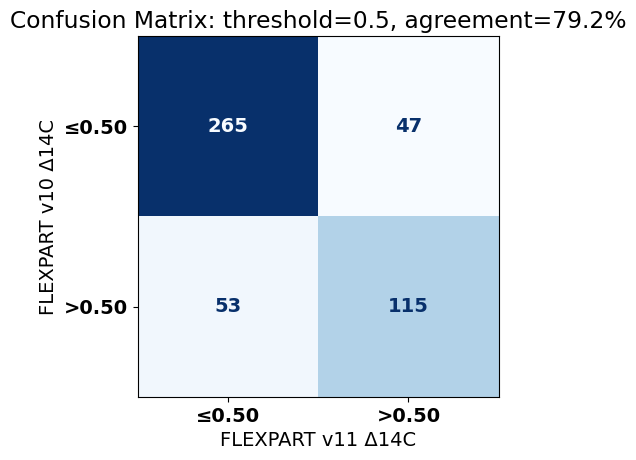

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Choose a threshold for classification (e.g., median of both datasets)
threshold = 0.5
# Create binary labels based on threshold
y_true = df_delta14C_v10["14C"] > threshold
y_pred = df_delta14C_v11["14C"] > threshold

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = round(np.sum(conf_matrix.diagonal())/np.sum(conf_matrix)*100,1)
labels = [f'≤{threshold:.2f}', f'>{threshold:.2f}']

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
ax.set_xlabel('FLEXPART v11 Δ14C')
ax.set_ylabel('FLEXPART v10 Δ14C')
ax.set_title(f'Confusion Matrix: threshold={threshold}, agreement={accuracy}%')
plt.tight_layout()
plt.show()

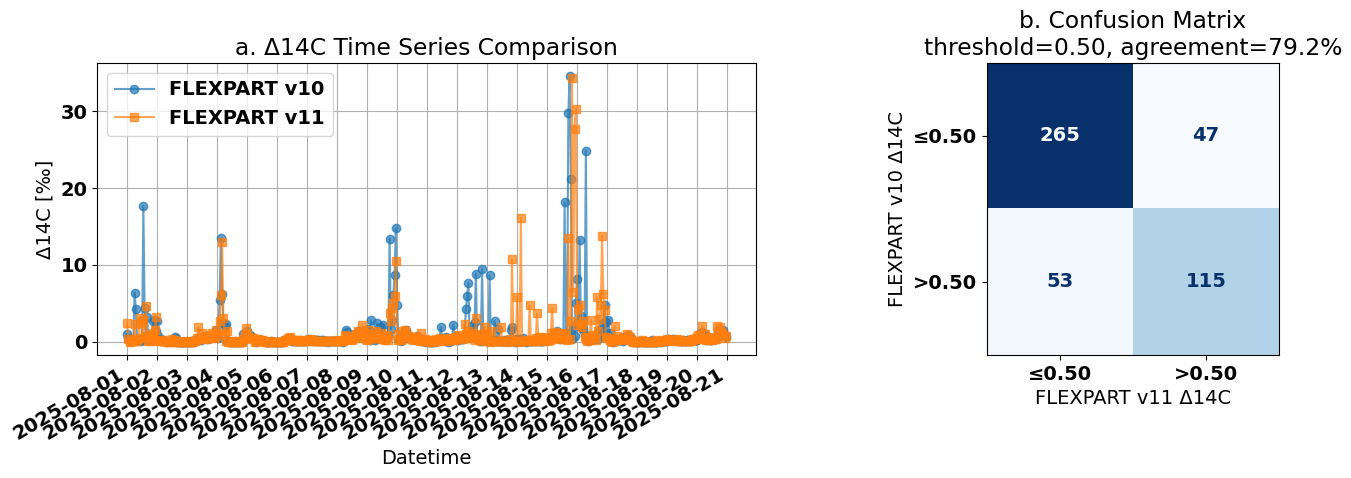

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate threshold for classification (median of both datasets)
threshold = 0.5

# Create binary labels based on threshold
y_true = df_delta14C_v10["14C"] > threshold
y_pred = df_delta14C_v11["14C"] > threshold

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = round(np.sum(conf_matrix.diagonal()) / np.sum(conf_matrix) * 100, 1)
labels = [f'≤{threshold:.2f}', f'>{threshold:.2f}']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# a. Δ14C Time Series Comparison
axs[0].plot(df_delta14C_v10['datetime'], df_delta14C_v10['14C'], label='FLEXPART v10', marker='o', linestyle='-', alpha=0.7)
axs[0].plot(df_delta14C_v11['datetime'], df_delta14C_v11['14C'], label='FLEXPART v11', marker='s', linestyle='-', alpha=0.7)
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('Δ14C [‰]')
axs[0].set_title('a. Δ14C Time Series Comparison')
axs[0].legend()
axs[0].grid(True)
unique_dates = pd.date_range(start=sdate, end=pd.to_datetime(edate) + pd.Timedelta(days=1), freq='D')
axs[0].set_xticks(unique_dates)
axs[0].set_xticklabels([d.strftime('%Y-%m-%d') for d in unique_dates], rotation=30, ha='right')

# b. Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(ax=axs[1], cmap=plt.cm.Blues, colorbar=False)
axs[1].set_xlabel('FLEXPART v11 Δ14C')
axs[1].set_ylabel('FLEXPART v10 Δ14C')
axs[1].set_title(f'b. Confusion Matrix\nthreshold={threshold:.2f}, agreement={accuracy}%')

plt.tight_layout()
fig.savefig(f"./plot/{StationID}_delta14C.png", dpi=300)
plt.show()

In [59]:
from matplotlib.backends.backend_pdf import PdfPages
import glob
from PIL import Image

# Find all PNG files matching pattern (e.g., StationID*.png)
# png_files = sorted(glob.glob(f"{StationID}*.png"))
png_files = [f"{StationID}_hourly_footprint.png", 
             f"{StationID}_daily_footprint.png",
             f"{StationID}_delta14C.png"]
# Create a PDF and add each image as a page
with PdfPages(f"./plot/{StationID}_combined_figures.pdf") as pdf:
    for fname in png_files:
        img = Image.open(f"./plot/{fname}")
        fig, ax = plt.subplots(figsize=(img.width / 100, img.height / 100), dpi=100)
        ax.imshow(img)
        ax.axis('off')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"Saved ./plot/{StationID}_combined_figures.pdf")

Saved ./plot/OPE120_combined_figures.pdf
